In [2]:
import numpy as np 
import torch 
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("/binf-isilon/renniegrp/vpx267/ucph_thesis/")
from model import TestMotifModel
from wrapper import utils
from torch.utils.data import DataLoader
from wrapper.data_setup import SequenceDatasetDual
from tqdm import tqdm
import gc
from wrapper import utils
import copy
import concurrent.futures
from typing import Iterable
import time

In [6]:
fold = 1
batch_size = 256
data_folder = "/binf-isilon/renniegrp/vpx267/ucph_thesis/data/dual_outputs"

seq_fasta_train_path = f"{data_folder}/motif_fasta_train_SPLIT_{fold}.fasta"
meta_data_train_json_path = f"{data_folder}/train_meta_data_SPLIT_{fold}.json"
train_dataset = SequenceDatasetDual(seq_fasta_path=seq_fasta_train_path, meta_data_path=meta_data_train_json_path)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

seq_fasta_test_path = f"{data_folder}/motif_fasta_test_SPLIT_{fold}.fasta"
meta_data_test_json_path = f"{data_folder}/test_meta_data_SPLIT_{fold}.json"
test_dataset = SequenceDatasetDual(seq_fasta_path=seq_fasta_test_path, meta_data_path=meta_data_test_json_path)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model_weight = torch.load(f"/binf-isilon/renniegrp/vpx267/ucph_thesis/data/outputs/models/trained_model_{fold}th_fold_dual_outputs_m6_info-no_promoter-False_MOTIF.pkl",
                        map_location=torch.device('cpu'))
config = {'cnn_first_filter': 16, 'cnn_first_kernel_size': 9, 'cnn_length': 3, 'cnn_filter': 32, 'cnn_kernel_size': 7, 'bilstm_layer': 3, 'bilstm_hidden_size': 128, 'fc_size': 64}            
model = TestMotifModel(input_channel=4, cnn_first_filter=config["cnn_first_filter"], cnn_first_kernel_size=config["cnn_first_kernel_size"],
                        cnn_other_filter=config["cnn_filter"], cnn_other_kernel_size=config["cnn_kernel_size"], bilstm_layer=config["bilstm_layer"], bilstm_hidden_size=config["bilstm_hidden_size"], fc_size=config["fc_size"],
                        output_size=2)
model.load_state_dict(model_weight)
seq_fasta_one_hot = utils.create_seq_tensor(seq_fasta_test_path)

/binf-isilon/renniegrp/vpx267/miniconda3/envs/thesis_ray_gpu/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [5]:

seq_fasta_one_hot = utils.create_seq_tensor(seq_fasta_test_path)

In [39]:
one_hot_size_mb = sys.getsizeof(seq_fasta_one_hot.storage())/(1024**2)
one_hot_size_single_mb = sys.getsizeof(seq_fasta_one_hot[0,:,:].storage())/(1024**2)
print(f"one hot data size: {one_hot_size_mb:,.3f}MB")
# param_size = 0
# for param in model.parameters():
#     param_size += param.nelement() * param.element_size()
# buffer_size = 0
# for buffer in model.buffers():
#     buffer_size += buffer.nelement() * buffer.element_size()

# size_all_mb = (param_size + buffer_size) / 1024**2
# print(f"model size: {size_all_mb:,.3f}MB")
print(f"Test data shape on fold-{fold}: {seq_fasta_one_hot.shape}. Note: it is estimated the same size for other folds.")
# Point wise mutation will generate 4*seq_length new sequences
print(f"Estimated size of total mutated data (single-nucleotide mutation): {one_hot_size_mb*3*seq_fasta_one_hot.shape[2]*0.001:,.3f}GB for each fold")

window_size = 5 
seq_length = 1001
total_sliding = 0
for i in range(0, seq_length-window_size+1):
    # print(f"i: {i}, i+window_size: {i+window_size-1}")
    total_sliding += 1
print(f"Estimated size of mutated data (sliding window with 'N' with size of {window_size}): {one_hot_size_single_mb*total_sliding*0.001:,.3f}GB for each fold")

one hot data size: 419.777MB
Test data shape on fold-1: torch.Size([27483, 4, 1001]). Note: it is estimated the same size for other folds.
Estimated size of total mutated data (single-nucleotide mutation): 1,260.589GB for each fold
Estimated size of mutated data (sliding window with 'N' with size of 5): 418.517GB for each fold


We can see that the size is too much for bulk analysis if we want to mutate all of the possible bases for each position. Hence we just need to focus on location of interest i.e. 50 up-down stream. Let's make estimation

In [40]:
slice_size = 100
print(f"Estimated size of sliced (with seq_length: {slice_size}) mutated data (single-nucleotide mutation): {one_hot_size_mb*3*slice_size*0.001:,.3f}GB for each fold")

seq_length = slice_size
total_sliding = 0
for i in range(0, seq_length-window_size+1):
    # print(f"i: {i}, i+window_size: {i+window_size-1}")
    total_sliding += 1
print(f"Estimated size of sliced data (sliding window with 'N' with size of {window_size}): {one_hot_size_single_mb*total_sliding*0.001:,.3f}GB for each fold")

Estimated size of sliced (with seq_length: 100) mutated data (single-nucleotide mutation): 125.933GB for each fold
Estimated size of sliced data (sliding window with 'N' with size of 5): 40.299GB for each fold


But, what if we create on the fly mutagenesis? i.e. looping through our sequences and create its mutagenesis score. It will be slower but more memory efficient!

In [4]:
def mutagenesis(x: torch.Tensor, model: torch.nn.Module, mutation_size :int=50, class_index: None|int=None, verbose: bool=True) -> np.ndarray:
    """ 
    in silico mutagenesis

    input: x: one-hot-encoded sequences with shape of (batch, seq_length, 4)
    input: model: trained model 

    """
    device = (torch.device("cuda") if torch.cuda.is_available()
            else torch.device("cpu"))

    if device == torch.device("cuda"):
        if not x.is_cuda:
            x = x.cuda()
        if next(model.parameters()).device == torch.device("cpu"): 
            model = model.cuda()
    
    model.eval()

    def generate_mutagenesis(x: np.ndarray, mutation_size: int) -> np.ndarray:
        """
        Assuming input sequence is odd, It will output single nucleotide mutation at each position of the input sequence except the middle position.
        It requires the mutation size to be even.
        
        param: x_copy: one-hot-encoded sequences with shape of (1, seq_length, 4)
        param: mutation_size: even number. Total mutation sites
        
        return: list of mutagenized one-hot-encoded sequences with shape of (1*mutation_size*3, seq_length, 4)  

        Example
        --------
        from wrapper import utils
        
        temp_seq = "ACATG"
        temp_seq_one_hot = torch.from_numpy(utils.one_hot(temp_seq))
        temp_seq_one_hot = temp_seq_one_hot.T.unsqueeze(0)
        muts = generate_mutagenesis(temp_seq_one_hot, mutation_size=2)
        print([utils.one_hot_to_sequence(mut) for mut in muts])
        """
        if isinstance(x, torch.Tensor):
            x_copy = copy.deepcopy(x)
            x_copy = x_copy.cpu().numpy()

        _,L,D = x_copy.shape 
        mid = L//2

        if mutation_size>(L-1):
            raise ValueError("Mutation size should be less than half of the sequence length.")
        elif mutation_size%2!=0:
            raise ValueError("Mutation size should be even number.")
        
        x_mut = np.zeros((mutation_size*3, L, D))
        k = 0
        for l in range(mid-int(mutation_size/2), mid+int(mutation_size/2)+1):
            if l==mid:
                continue
            for d in range(3):
                if x_copy[0,l,d]==1:
                    continue
                x_new = copy.deepcopy(x_copy)
                x_new[0,l,:] = 0
                x_new[0,l,d] = 1
                x_mut[k] = x_new
                k += 1
        return x_mut

    def get_score(x: torch.Tensor, model: torch.nn.Module, class_index: int=None, batch_size=32) -> np.ndarray:
        """
        Get score from the model and process based on class_index.

        param: x: torch.Tensor: one-hot-encoded sequences with shape of (batch, seq_length, 4)
        param: model: torch.nn.Module: trained model
        param: class_index: int: class index to choose from the model output 0 (control) or 1 (case)

        return: score: np.ndarray: model predictions with shape of (batch, 1)

        Example
        --------
        get_score(seq_fasta_one_hot[0:30,:,:], model, class_index=0)
        """
        if class_index not in [0,1]:
            raise ValueError("class_index should be either 0 or 1.")

        if torch.cuda.is_available():
            device = torch.device("cuda")
            if not x.is_cuda:
                x = x.cuda()
            if next(model.parameters()).device == torch.device("cpu"): 
                model = model.cuda()
        else:
            device = torch.device("cpu")
        
        if x.shape[2]==4:
            x = x.permute(0,2,1)
            
        x_loader = torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=False)
        score = torch.Tensor().to(device)

        model.eval()

        for data in x_loader:
            pred = model(data) # [batch_size, 2]
            score = torch.cat([score, pred.detach()])
        score = score.detach().cpu().numpy()
        if class_index == None:
            # Square root of sum of squares of all classes for each sequence
            score = np.sqrt(np.sum(score**2, axis=-1, keepdims=True)) # [batch_size, 1]
        else:
            # Choosing class based on class_index
            score = score[:,class_index]
        return score

    with torch.no_grad():
        # generate mutagenized sequences
        if verbose:
            print("Generating mutagenized sequences...")
        x_mut = generate_mutagenesis(x, mutation_size)
        x_mut = torch.from_numpy(x_mut).float().to(device) # (mutation_size*3, seq_length, 4)  
        
        # get baseline wildtype score
        if verbose:
            print("Getting baseline wildtype score...")
        wt_score = get_score(x, model, class_index) # [1,] 
        predictions = get_score(x_mut, model, class_index) # [mutation_size * 3,]
        delta = predictions - wt_score 
        # mutation_size = 4
        # temp1 = torch.Tensor([[1,2,3,4,5,6,7,8,9,10,11,12]])
        # temp1 = temp1.reshape(mutation_size,3).T
        # print(temp1)
        delta = delta.reshape(mutation_size,3).T # [3, mutation_size]

    return delta

In [260]:
seqs_number = seq_fasta_one_hot.shape[0]
input_seq = seq_fasta_one_hot[0:seqs_number,:,:]
print(input_seq.shape)
mutation_size=500

ctrl_mutant_score_diff = []
case_mutant_score_diff = []
for i in tqdm(range (input_seq.shape[0]), desc="Mutagenesis Score"):
    ctrl_mutant_score_diff.append(mutagenesis(x=input_seq[i:i+1,:,:].transpose(1,2), model=model, mutation_size=mutation_size, class_index=0, verbose=False))
    case_mutant_score_diff.append(mutagenesis(x=input_seq[i:i+1,:,:].transpose(1,2), model=model, mutation_size=mutation_size, class_index=1, verbose=False))
    
ctrl_mutant_score_diff = np.vstack(np.array(ctrl_mutant_score_diff))
case_mutant_score_diff = np.vstack(np.array(case_mutant_score_diff))


torch.Size([27483, 4, 1001])


Mutagenesis Score: 100%|██████████| 27483/27483 [1:59:03<00:00,  3.85it/s]


In [262]:
# Save into npz 
np.savez(f"/binf-isilon/renniegrp/vpx267/ucph_thesis/analysis/mutagenesis_score_fold_{fold}.npz", ctrl_mutant_score_diff=ctrl_mutant_score_diff, case_mutant_score_diff=case_mutant_score_diff)

In [4]:
fold = 2
mutagenesis_data =  np.load(f"/binf-isilon/renniegrp/vpx267/ucph_thesis/analysis/mutagenesis_score_fold_{fold}.npz")
ctrl_mutant_score_diff = mutagenesis_data["ctrl_mutant_score_diff"] # Shape: ~80k data
case_mutant_score_diff = mutagenesis_data["case_mutant_score_diff"]

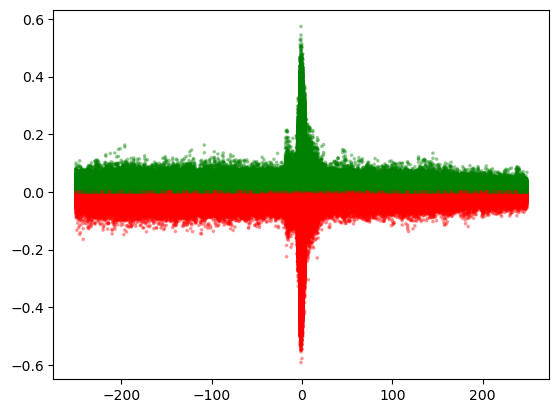

In [82]:
from multiprocessing import Pool
import time

data = ctrl_mutant_score_diff
mutation_size = 500
x = np.arange(-mutation_size/2, mutation_size/2)
# Function to process data chunks


def process_chunk(slice_range: list[tuple[int,int]]):
    start, end = slice_range
    x_batch = np.tile(x, (end - start, 1)).ravel()
    y_batch = data[start:end].ravel()
    colors = np.where(y_batch > 0, 'green', 'red')
    return (x_batch, y_batch, colors)

# Split data indices into chunks for multiprocessing

from typing import Iterable
import typing

def create_chunks(data: Iterable, num_chunks: int=1) -> list[tuple[int,int]]:
    # create_chunks([1,2,3,4,4,5,6,6], 3)
    # [(0, 2), (2, 4), (4, 6), (6, 8)]
    chunk_size = len(data) // num_chunks
    return [(i, min(i + chunk_size, len(data))) for i in range(0, len(data), chunk_size)]


num_processes = 40  # or the number of cores you have
chunks = create_chunks(data, num_processes)

# Use multiprocessing to process data
with Pool(num_processes) as pool:
    results = pool.map(process_chunk, chunks)


def plot_chunk(result):
    ax.scatter(result[0], result[1], color=result[2], alpha=0.3, s=3)

def inter_chunk(result):
    return result
    
from multiprocessing import Manager

with Manager() as manager:
    fig, ax = plt.subplots()
    with concurrent.futures.ProcessPoolExecutor(max_workers=num_processes) as executor:
        futures = [executor.submit(inter_chunk, result) for result in results]
        for future in concurrent.futures.as_completed(futures):
            result = future.result()
            plot_chunk(result)

#     # Setting labels and titles
#     ax.set_xlabel('Position (centered at m6A site)')
#     ax.set_ylabel('$\Delta$ m6A Level')
#     ax.set_title('Control Delta Mutagenesis')
#     plt.show()
#     fig.savefig('mult_process_coba.png')


plt.show()

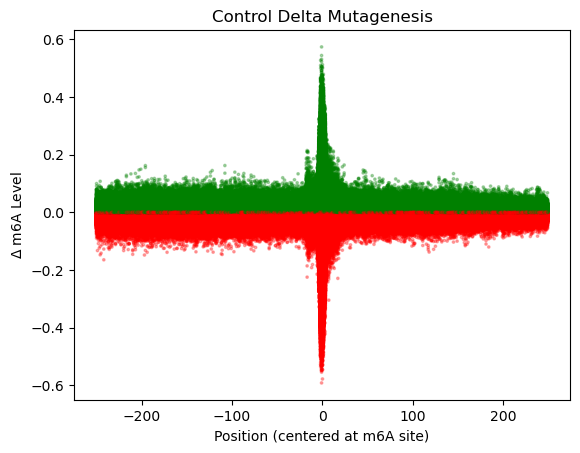

In [81]:
from multiprocessing import Pool

data = ctrl_mutant_score_diff
mutation_size = 500
x = np.arange(-mutation_size/2, mutation_size/2)
# Function to process data chunks


def process_chunk(slice_range: list[tuple[int,int]]):
    start, end = slice_range
    x_batch = np.tile(x, (end - start, 1)).ravel()
    y_batch = data[start:end].ravel()
    colors = np.where(y_batch > 0, 'green', 'red')
    return (x_batch, y_batch, colors)

# Split data indices into chunks for multiprocessing

from typing import Iterable
import typing

def create_chunks(data: Iterable, num_chunks: int=1) -> list[tuple[int,int]]:
    # create_chunks([1,2,3,4,4,5,6,6], 3)
    # [(0, 2), (2, 4), (4, 6), (6, 8)]
    chunk_size = len(data) // num_chunks
    return [(i, min(i + chunk_size, len(data))) for i in range(0, len(data), chunk_size)]


num_processes = 40  # or the number of cores you have
chunks = create_chunks(data, num_processes)

# Use multiprocessing to process data
with Pool(num_processes) as pool:
    results = pool.map(process_chunk, chunks)

# Plotting
fig, ax = plt.subplots()
for x_batch, y_batch, colors in results:
    ax.scatter(x_batch, y_batch, color=colors, alpha=0.3, s=3)

# Setting labels and titles
ax.set_xlabel('Position (centered at m6A site)')
ax.set_ylabel('$\Delta$ m6A Level')
ax.set_title('Control Delta Mutagenesis')
plt.show()

In [289]:
from multiprocessing import Pool

data = ctrl_mutant_score_diff[:, 200:300]
mutation_size = 100
x = np.arange(-mutation_size/2, mutation_size/2)
# Function to process data chunks
def process_chunk(slice_range):
    start, end = slice_range
    x_batch = np.tile(x, (end - start, 1)).ravel()
    y_batch = data[start:end].ravel()
    colors = np.where(y_batch > 0, 'green', 'red')
    return (x_batch, y_batch, colors)

# Split data indices into chunks for multiprocessing
def create_chunks(data, num_chunks):
    chunk_size = len(data) // num_chunks
    return [(i, min(i + chunk_size, len(data))) for i in range(0, len(data), chunk_size)]



num_processes = 10  # or the number of cores you have
chunks = create_chunks(data, num_processes)

# Use multiprocessing to process data
with Pool(num_processes) as pool:
    results = pool.map(process_chunk, chunks)

# Plotting
fig, ax = plt.subplots()
for x_batch, y_batch, colors in results:
    ax.scatter(x_batch, y_batch, color=colors, alpha=0.3, s=3)

# Setting labels and titles
ax.set_xlabel('Position (centered at m6A site)')
ax.set_ylabel('$\Delta$ m6A Level')
ax.set_title('Control Delta Mutagenesis')
plt.show()


(82449, 0)
(100,)
(824400,), (824400,),
(824400,), (824400,),
(824400,), (824400,),
(824400,), (824400,),
(824400,), (824400,),


In [ ]:
# Example data (replace this with your actual numpy array)
data = ctrl_mutant_score_diff
mutation_size = 500
# Generate x values: from -100 to 99
x = np.arange(-mutation_size/2, mutation_size/2)

# Plotting each row against x
fig, ax = plt.subplots()
for i in range(data.shape[0]):
    # Determine colors for each point based on its sign
    colors = ['green' if value > 0 else 'red' for value in data[i]]
    
    # Scatter plot with conditional coloring
    ax.scatter(x, data[i], color=colors, alpha=0.3, s=3)

# Adding labels and legend
ax.set_xlabel('Position (centered at m6A site)')
ax.set_ylabel('$\Delta$ m6A Level')
ax.set_title('Control Delta Mutagenesis')
ax.legend()

# Show the plot
plt.show()

In [ ]:
# Example data (replace this with your actual numpy array)
data = ctrl_mutant_score_diff
mutation_size = 100
# Generate x values: from -100 to 99
x = np.arange(-mutation_size/2, mutation_size/2)

# Plotting each row against x
fig, ax = plt.subplots()
for i in range(data.shape[0]):
    # Determine colors for each point based on its sign
    colors = ['green' if value > 0 else 'red' for value in data[i]]
    
    # Scatter plot with conditional coloring
    ax.scatter(x, data[i], color=colors, alpha=0.3, s=3)

# Adding labels and legend
ax.set_xlabel('Position (centered at m6A site)')
ax.set_ylabel('$\Delta$ m6A Level')
ax.set_title('Control Delta Mutagenesis')
ax.legend()

# Show the plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


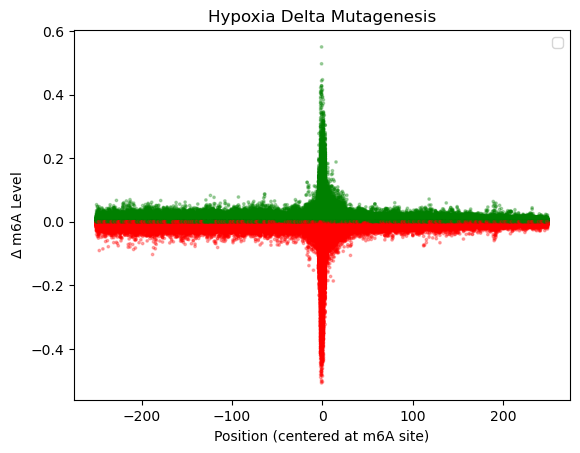

In [ ]:
# Example data (replace this with your actual numpy array)
data = case_mutant_score_diff

# Generate x values: from -100 to 99
x = np.arange(-mutation_size/2, mutation_size/2)

# Plotting each row against x
fig, ax = plt.subplots()
for i in range(data.shape[0]):
    # Determine colors for each point based on its sign
    colors = ['green' if value > 0 else 'red' for value in data[i]]
    
    # Scatter plot with conditional coloring
    ax.scatter(x, data[i], color=colors, alpha=0.3, s=3)

# Adding labels and legend
ax.set_xlabel('Position (centered at m6A site)')
ax.set_ylabel('$\Delta$ m6A Level')
ax.set_title('Hypoxia Delta Mutagenesis')
ax.legend()

# Show the plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


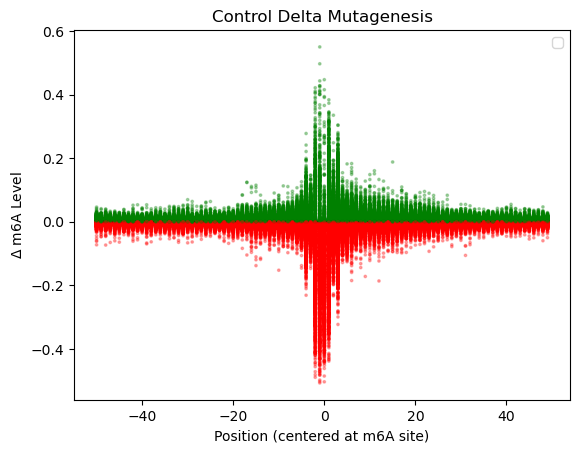

In [ ]:
# Example data (replace this with your actual numpy array)
data = case_mutant_score_diff

x = np.arange(-50, 50)

# Plotting each row against x
fig, ax = plt.subplots()
for i in range(data.shape[0]):
    # Determine colors for each point based on its sign
    colors = ['green' if value > 0 else 'red' for value in data[i][200:300]]
    # Scatter plot with conditional coloring
    ax.scatter(x, data[i][200:300], color=colors, alpha=0.3, s=3)

# Adding labels and legend
ax.set_xlabel('Position (centered at m6A site)')
ax.set_ylabel('$\Delta$ m6A Level')
ax.set_title('Hypoxia Delta Mutagenesis')
ax.legend()

# Show the plot
plt.show()

# LOOPING FOR REPORT

In [5]:
for fold in [5]:
    print(f"Starting generating mutagenesis for fold {fold}")

    print("Loading model...")
    config = {'cnn_first_filter': 16, 'cnn_first_kernel_size': 9, 'cnn_length': 3, 'cnn_filter': 32, 'cnn_kernel_size': 7, 'bilstm_layer': 3, 'bilstm_hidden_size': 128, 'fc_size': 64}            
    model = TestMotifModel(input_channel=4, cnn_first_filter=config["cnn_first_filter"], cnn_first_kernel_size=config["cnn_first_kernel_size"],
                            cnn_other_filter=config["cnn_filter"], cnn_other_kernel_size=config["cnn_kernel_size"], bilstm_layer=config["bilstm_layer"], bilstm_hidden_size=config["bilstm_hidden_size"], fc_size=config["fc_size"],
                            output_size=2)
    model_weight = torch.load(f"/binf-isilon/renniegrp/vpx267/ucph_thesis/data/outputs/models/trained_model_{fold}th_fold_dual_outputs_m6_info-no_promoter-False_MOTIF.pkl",
                            map_location=torch.device('cpu'))
    model.load_state_dict(model_weight)
    model.eval()

    seq_fasta_test_path = f"/binf-isilon/renniegrp/vpx267/ucph_thesis/data/dual_outputs/motif_fasta_test_SPLIT_{fold}.fasta"
    seq_fasta_one_hot = utils.create_seq_tensor(seq_fasta_test_path)

    seqs_number = seq_fasta_one_hot.shape[0]
    input_seq = seq_fasta_one_hot[0:seqs_number,:,:]
    mutation_size=500

    print(f"Input test shape: {input_seq.shape} | Mutation size = 500")
    ctrl_mutant_score_diff = []
    case_mutant_score_diff = []
    for i in tqdm(range (input_seq.shape[0]), desc=f"Mutagenesis Score fold {fold}"):
        ctrl_mutant_score_diff.append(mutagenesis(x=input_seq[i:i+1,:,:].transpose(1,2), model=model, mutation_size=mutation_size, class_index=0, verbose=False))
        case_mutant_score_diff.append(mutagenesis(x=input_seq[i:i+1,:,:].transpose(1,2), model=model, mutation_size=mutation_size, class_index=1, verbose=False))
        
    ctrl_mutant_score_diff = np.vstack(np.array(ctrl_mutant_score_diff))
    case_mutant_score_diff = np.vstack(np.array(case_mutant_score_diff))

    print("Saving...")
    np.savez(f"/binf-isilon/renniegrp/vpx267/ucph_thesis/analysis/mutagenesis_score_fold_{fold}.npz", ctrl_mutant_score_diff=ctrl_mutant_score_diff, case_mutant_score_diff=case_mutant_score_diff)


Starting generating mutagenesis for fold 5
Loading model...
Input test shape: torch.Size([25493, 4, 1001]) | Mutation size = 500


Mutagenesis Score fold 5: 100%|██████████| 25493/25493 [1:48:02<00:00,  3.93it/s]


Saving...
